<a href="https://colab.research.google.com/github/ShaoFuLiu/tSDRG_DataAnalysis/blob/master/TestSortingData_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **tSDRG Data Analysis**

### 1. **Before start plotting, please change the file path "myfile = ..." to your metadata directory.**
### 2. **Dim / Jdis = Dimerization / Randomness strength** 

### 3. **DimABC / JdisABC = Dimerization A.BC / Randomness strength A.BC**
### &emsp;*example: Dim123 = Dimerization 1.23*

# **Import lib and set basic parameter**

In [ ]:
## Import library
import os
import math
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', '^-', 'x-', 's-', 'p-', '*-', 'h-']   ## marker array
marr_nl = ['o', '^', 'x', 's', 'p', '*', 'h']       ## marker array (no line)

spin = int(1)                                       ## Spin type
BC = 'PBC'                                          ## Boundary condition
P = 10                                              ## Random distribution type (10 == Exponential distribution)
M = 30                                              ## Bound dimension 
font_size = 30

ALL_Dimer = ["Dim000"]
ALL_Jdis = ["Jdis000"]

Ddiff = 1
init_D = 0      ## Dim000 = 0.00
final_D = 100   ## Dim100 = 1.00
ds = (final_D - init_D)/Ddiff-1
for i in range (int(ds)+1):
    strD = "Dim00" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 10):
        strD = "Dim0" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 100):
        strD = "Dim" + str((i+1)*Ddiff+init_D) 
    ALL_Dimer.append(strD)

Jdiff = 1
init_J = 0      ## Jdis000 = 0.00
final_J = 200   ## Jdis200 = 2.00
js = (final_J - init_J)/Jdiff-1
for i in range (int(js)+1):
    strJ = "Jdis00" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 10):
        strJ = "Jdis0" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 100):
        strJ = "Jdis" + str((i+1)*Jdiff+init_J)
    ALL_Jdis.append(strJ)
# print(ALL_Dimer) ## ALL_Dimer = [Dim000, Dim001, ... , Dim099, Dim100]
# print(ALL_Jdis)  ## ALL_Jdis = [Jdis000, Jdis001, ... , Jdis599, Jdis200]

# **Define function**

In [ ]:
def find_id(f_diff):                ## find crossing point index
    ids = []
    for id in range(len(f_diff)-1):
        if (np.sign(f_diff['diff'][id]) != np.sign(f_diff['diff'][id+1])):
            ids.append(id)
    if (len(ids) == 0):
        raise ValueError('no crossing point')
    return ids

def fitting_point(f_L1, f_L2, ids, var, para, n_point):
    x = []
    y = []
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
        x0 = (b2-b1)/(a1-a2)
        y0 = a1*x0 + b1
        x.append(x0)
        y.append(y0)
    return x, y

# **Start plot**

## Fix **<font color = yellow>J</font>**, look **<font color = red>L</font>**, **Order Parameter** vs **<font color = green>D</font>**

In [ ]:
# 固定J, 看L, ZL 對 D 的圖(橫切)

OrderPara = "ZL"                 ## Choose SOP or ZL
Ls = [16,32,48,64]               ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis000"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(30,15))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                # print("no file call: " + myfile)
                continue

            df = pd.read_csv(myfile)

            mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        ax.plot(dfplt['Dimer'], dfplt[Para], "o-", color=carr[l], markersize = 8, label = 'L=%d' %(L))
        ax.errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=15, capthick=2, color=carr[l], label=None)
        ax.set_xlabel(r'$D$', fontsize=30)
        ax.set_ylabel(ylable, fontsize=30)
        ax.tick_params(axis='x', labelsize=20) 
        ax.tick_params(axis='y', labelsize=20)
        ax.set_title("Jdis = %.2f" %(J), fontsize=30)
        ax.grid(linestyle='-', linewidth=1)
        # ax.set_xlim([0.45, 0.65])
        # ax.set_ylim([-0.3, 0.2])
        ax.legend(loc = 'best',fontsize=30)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=30)
# fig.legend(lines, labels, fontsize=30)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show() 

## Fix **<font color = yellow>J</font>**, look **<font color = red>L</font>**, **Order Parameter** vs **<font color = green>D</font>**, Multiplot

### **<font color = yellow>J</font>** = 0 ~ 0.7

In [ ]:
# 固定J, 看L, ZL 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,88,96]             ## Choose size 
# Ls = [16,32,48,64]
Dimer = ALL_Dimer
Jdis = ["Jdis000","Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], "o-", color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], "o-", color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=15, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        # ax[int(j/2)][j-2*int(j/2)].set_xlim([0.45, 0.65])
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([-0.3, 0.2])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()

In [ ]:
# 固定J, 看L, Oz 對 D 的圖(橫切)
OrderPara = "SOP"                ## Choose SOP or ZL
Ls = [16,32,48,64]               ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis000","Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        # ax[int(j/2)][j-2*int(j/2)].set_xlim([0., 1])
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([0, 0.25])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()

### **<font color = yellow>J</font>** = 0.8 ~ 1.08

In [ ]:
# 固定J, 看L, ZL 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
Ls = [16,32,48,64]              ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis080","Jdis090","Jdis095","Jdis096","Jdis097","Jdis098","Jdis099","Jdis100","Jdis101","Jdis102","Jdis103","Jdis104","Jdis105","Jdis106","Jdis107","Jdis108"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        # ax[int(j/2)][j-2*int(j/2)].set_xlim([0, 0.2])
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([0.15, 0.225])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()

In [ ]:
# 固定J, 看L, Oz 對 D 的圖(橫切)

OrderPara = "SOP"                ## Choose SOP or ZL
Ls = [16,32,48,64]              ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis080","Jdis090","Jdis095","Jdis096","Jdis097","Jdis098","Jdis099","Jdis100","Jdis101","Jdis102","Jdis103","Jdis104","Jdis105","Jdis106","Jdis107","Jdis108"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(8, 2, constrained_layout=True, figsize=(30,60))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        # ax[int(j/2)][j-2*int(j/2)].set_xlim([0, 1])
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([-0.15, 0.1])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()  

### **<font color = yellow>J</font>** = 1.09 ~ 2

In [ ]:
# 固定J, 看L, ZL 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
Ls = [16,32,48,64]               ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis109","Jdis110","Jdis111","Jdis112","Jdis113","Jdis114","Jdis115","Jdis120","Jdis130","Jdis140","Jdis150","Jdis160","Jdis170","Jdis180","Jdis190","Jdis200"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        # ax[int(j/2)][j-2*int(j/2)].set_xlim([0, 0.6])                       ## set x limit
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([-0.01, 0.03])                  ## set y limit
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()

In [ ]:
# 固定J, 看L, Oz 對 D 的圖(橫切)

OrderPara = "SOP"                ## Choose SOP or ZL
Ls = [16,32,48,64]               ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis109","Jdis110","Jdis111","Jdis112","Jdis113","Jdis114","Jdis115","Jdis120","Jdis130","Jdis140","Jdis150","Jdis160","Jdis170","Jdis180","Jdis190","Jdis200"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([-0.01, 0.03])                  ## set y limit
        # ax[int(j/2)][j-2*int(j/2)].set_xlim([0, 0.6])                       ## set x limit
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()

## **fitting and find crossing point (橫切)** 

In [ ]:
OrderPara = "ZL"

if (OrderPara == "SOP"):
    Para = "O^z"
    plt.ylabel(r'$O^z(r=L/2)$_diff', fontsize=font_size)
if (OrderPara == "ZL"):
    Para = "ZL"
    plt.ylabel(r'$ZL$_diff', fontsize=font_size)

# Ls = [16,24,32,40,48,56,64,72,80,88,96,128]
Ls = [16,32,48,64]
# Jdis = ["Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060"]
Jdis = ["Jdis050"]
Dimer = ALL_Dimer[25:66]
n_point = 4

for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
    print("\n-------------------- J = "+ str(J) +" --------------------")
    print("         D1", "                  D2")
    D1 = []
    D2 = []

    for l in range(len(Ls)-1):
        L1 = Ls[l]
        L2 = Ls[l+1]
        f_L1 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_L2 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_diff = pd.DataFrame(columns = ['Dimer', 'diff'])
        ignore_num = 0

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        
            file_L1 = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M)\
            +'_'+ OrderPara +'.csv'
            file_L2 = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M)\
            +'_'+ OrderPara +'.csv'
            
            if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                ignore_num += 1
                continue
        
            df_L1 = pd.read_csv(file_L1)
            df_L2 = pd.read_csv(file_L2)

            if (OrderPara == "SOP"):
                mean_L1 = {'Dimer':D, 'ZL':-df_L1[Para][0]}
                mean_L2 = {'Dimer':D, 'ZL':-df_L2[Para][0]}
                mean_diff = {'Dimer':D, 'diff':df_L1[Para][0]-df_L2[Para][0]}
            else:
                mean_L1 = {'Dimer':D, 'ZL':df_L1[Para][0]}
                mean_L2 = {'Dimer':D, 'ZL':df_L2[Para][0]}
                mean_diff = {'Dimer':D, 'diff':df_L2[Para][0]-df_L1[Para][0]}

            f_L1.loc[d-ignore_num] = mean_L1
            f_L2.loc[d-ignore_num] = mean_L2
            f_diff.loc[d-ignore_num] = mean_diff

        if (ignore_num == 66-25):
            print(L1)

        plt.plot(f_diff['Dimer'], f_diff['diff'], "o-", color=carr[l], markersize = font_size/3, linewidth = font_size/15, label = 'L%d-L%d' %(L2,L1))
        plt.plot(f_diff['Dimer'], 0*f_diff['diff'], "-", color="red", markersize = font_size/3, linewidth = font_size/15)

        ids = find_id(f_diff)
        Ds, ys = fitting_point(f_L1, f_L2, ids, "Dimer", Para, n_point)
        print(("L"+str(L2)+"-"+"L"+str(L1)), Ds)
        D1.append(Ds[0])
        # D2.append(Ds[1])

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$D$', fontsize=font_size)
# plt.xlim(0.4, 0.7)
# plt.ylim(0.1, 0.3)
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, Jdis = %.2f' % (spin, M, J), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Fix **<font color = green>D</font>**, look **<font color = red>L</font>**, **Order Parameter** vs **<font color = yellow>J</font>**

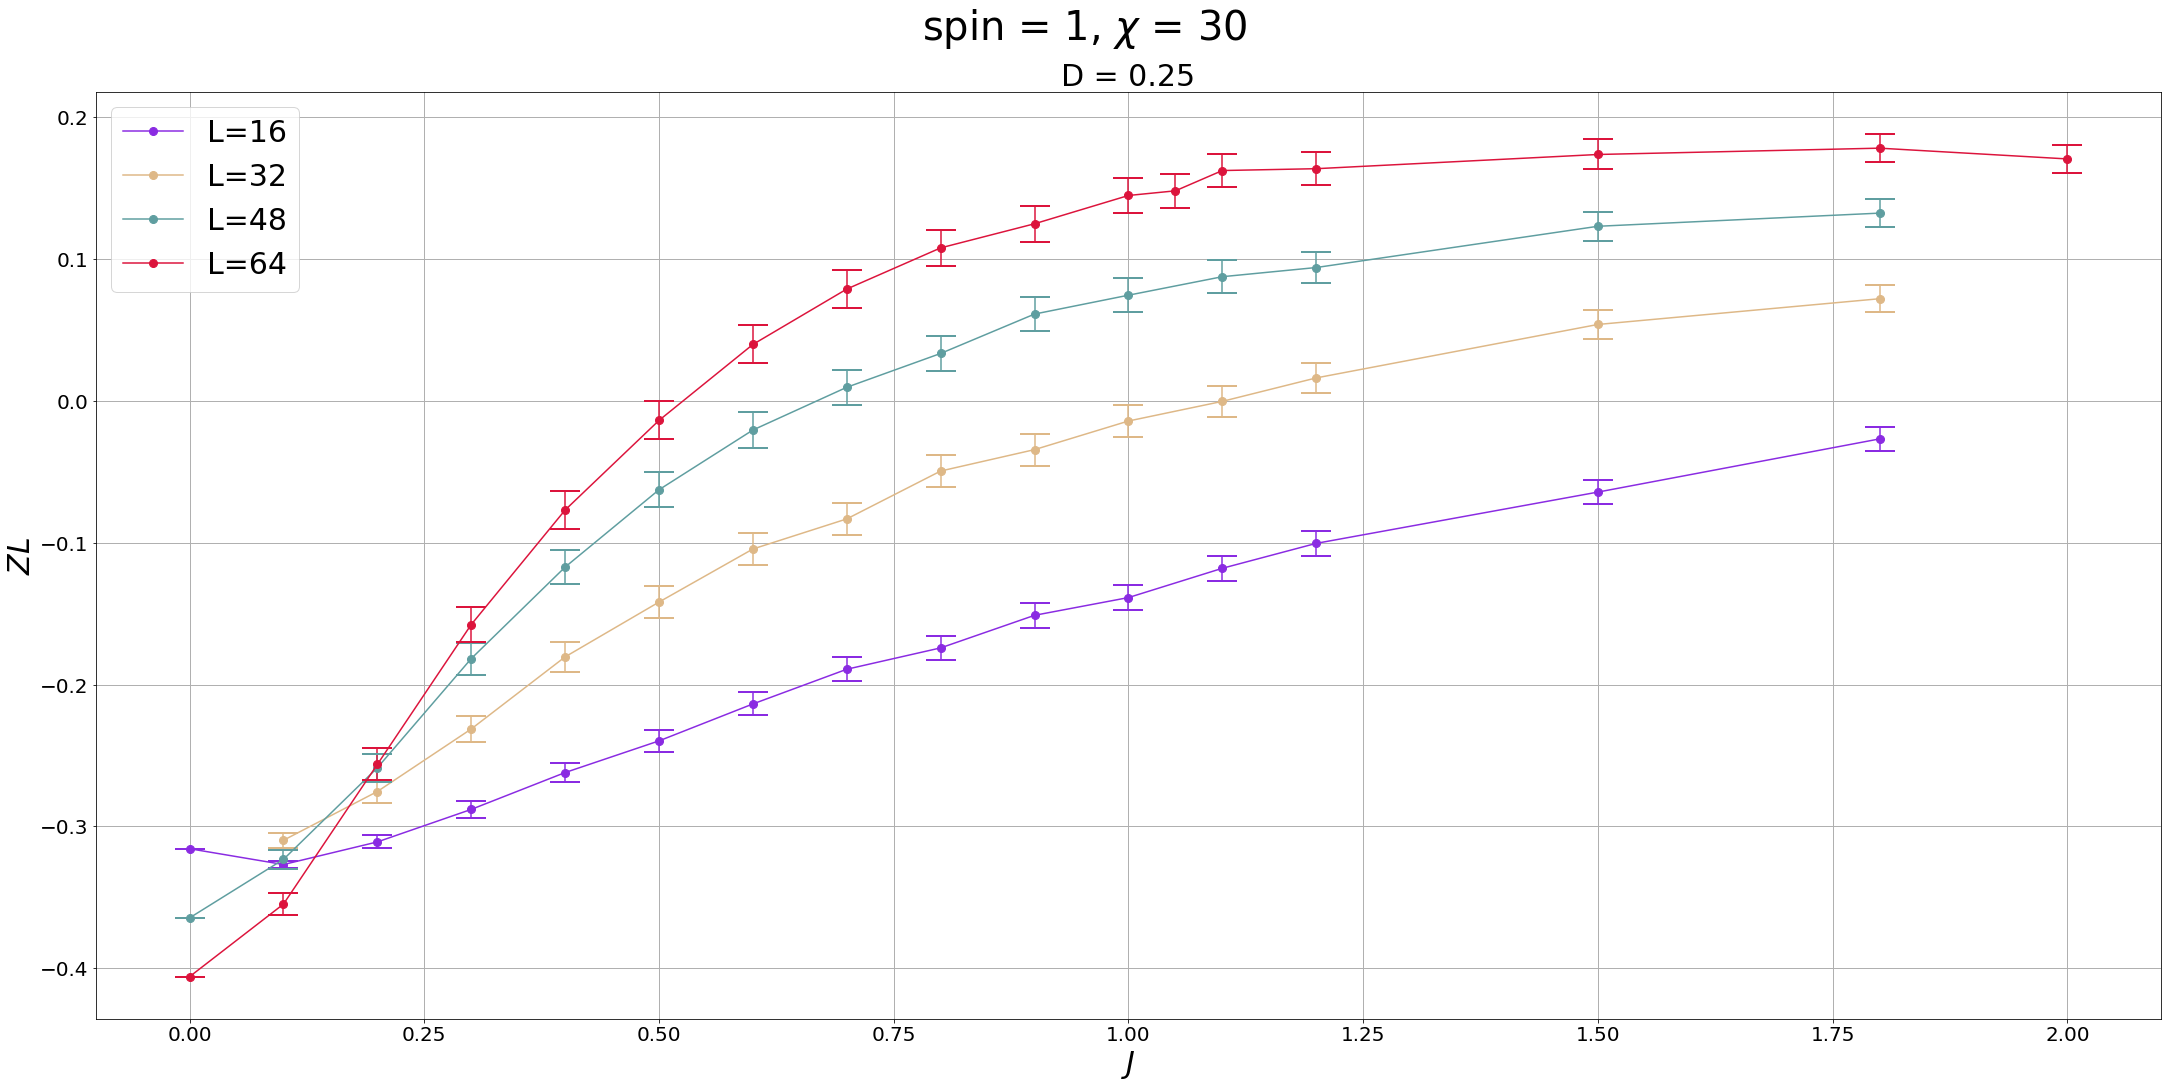

In [56]:
# 固定J, 看L, ZL 對 D 的圖(橫切)

OrderPara = "ZL"                                    ## Choose SOP or ZL
Ls = [16,32,48,64]
# Ls = [16,24,32,40,48,56,64,72,80,88,96]             ## Choose size 
Dimer = ["Dim025"]
Jdis = ALL_Jdis

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(30,15))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for d in range(len(Dimer)):        
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])    

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        
            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        ax.plot(dfplt['Jdis'], dfplt[Para], "o-", color=carr[l], markersize = 8, label = 'L=%d' %(L))
        ax.errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=15, capthick=2, color=carr[l], label=None)
        ax.set_xlabel(r'$J$', fontsize=30)
        ax.set_ylabel(ylable, fontsize=30)
        ax.tick_params(axis='x', labelsize=20) 
        ax.tick_params(axis='y', labelsize=20)
        ax.set_title("D = %.2f" %(D), fontsize=30)
        ax.grid(linestyle='-', linewidth=1)
        # ax.set_xlim([0.45, 0.65])
        # ax.set_ylim([-0.3, 0.2])
        ax.legend(loc = 'best',fontsize=30)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)

# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show() 

## Fix **<font color = green>D</font>**, look **<font color = red>L</font>**, **Order Parameter** vs **<font color = yellow>J</font>**, Multiplot

### **<font color = green>D</font>** = 0 ~ 0.10

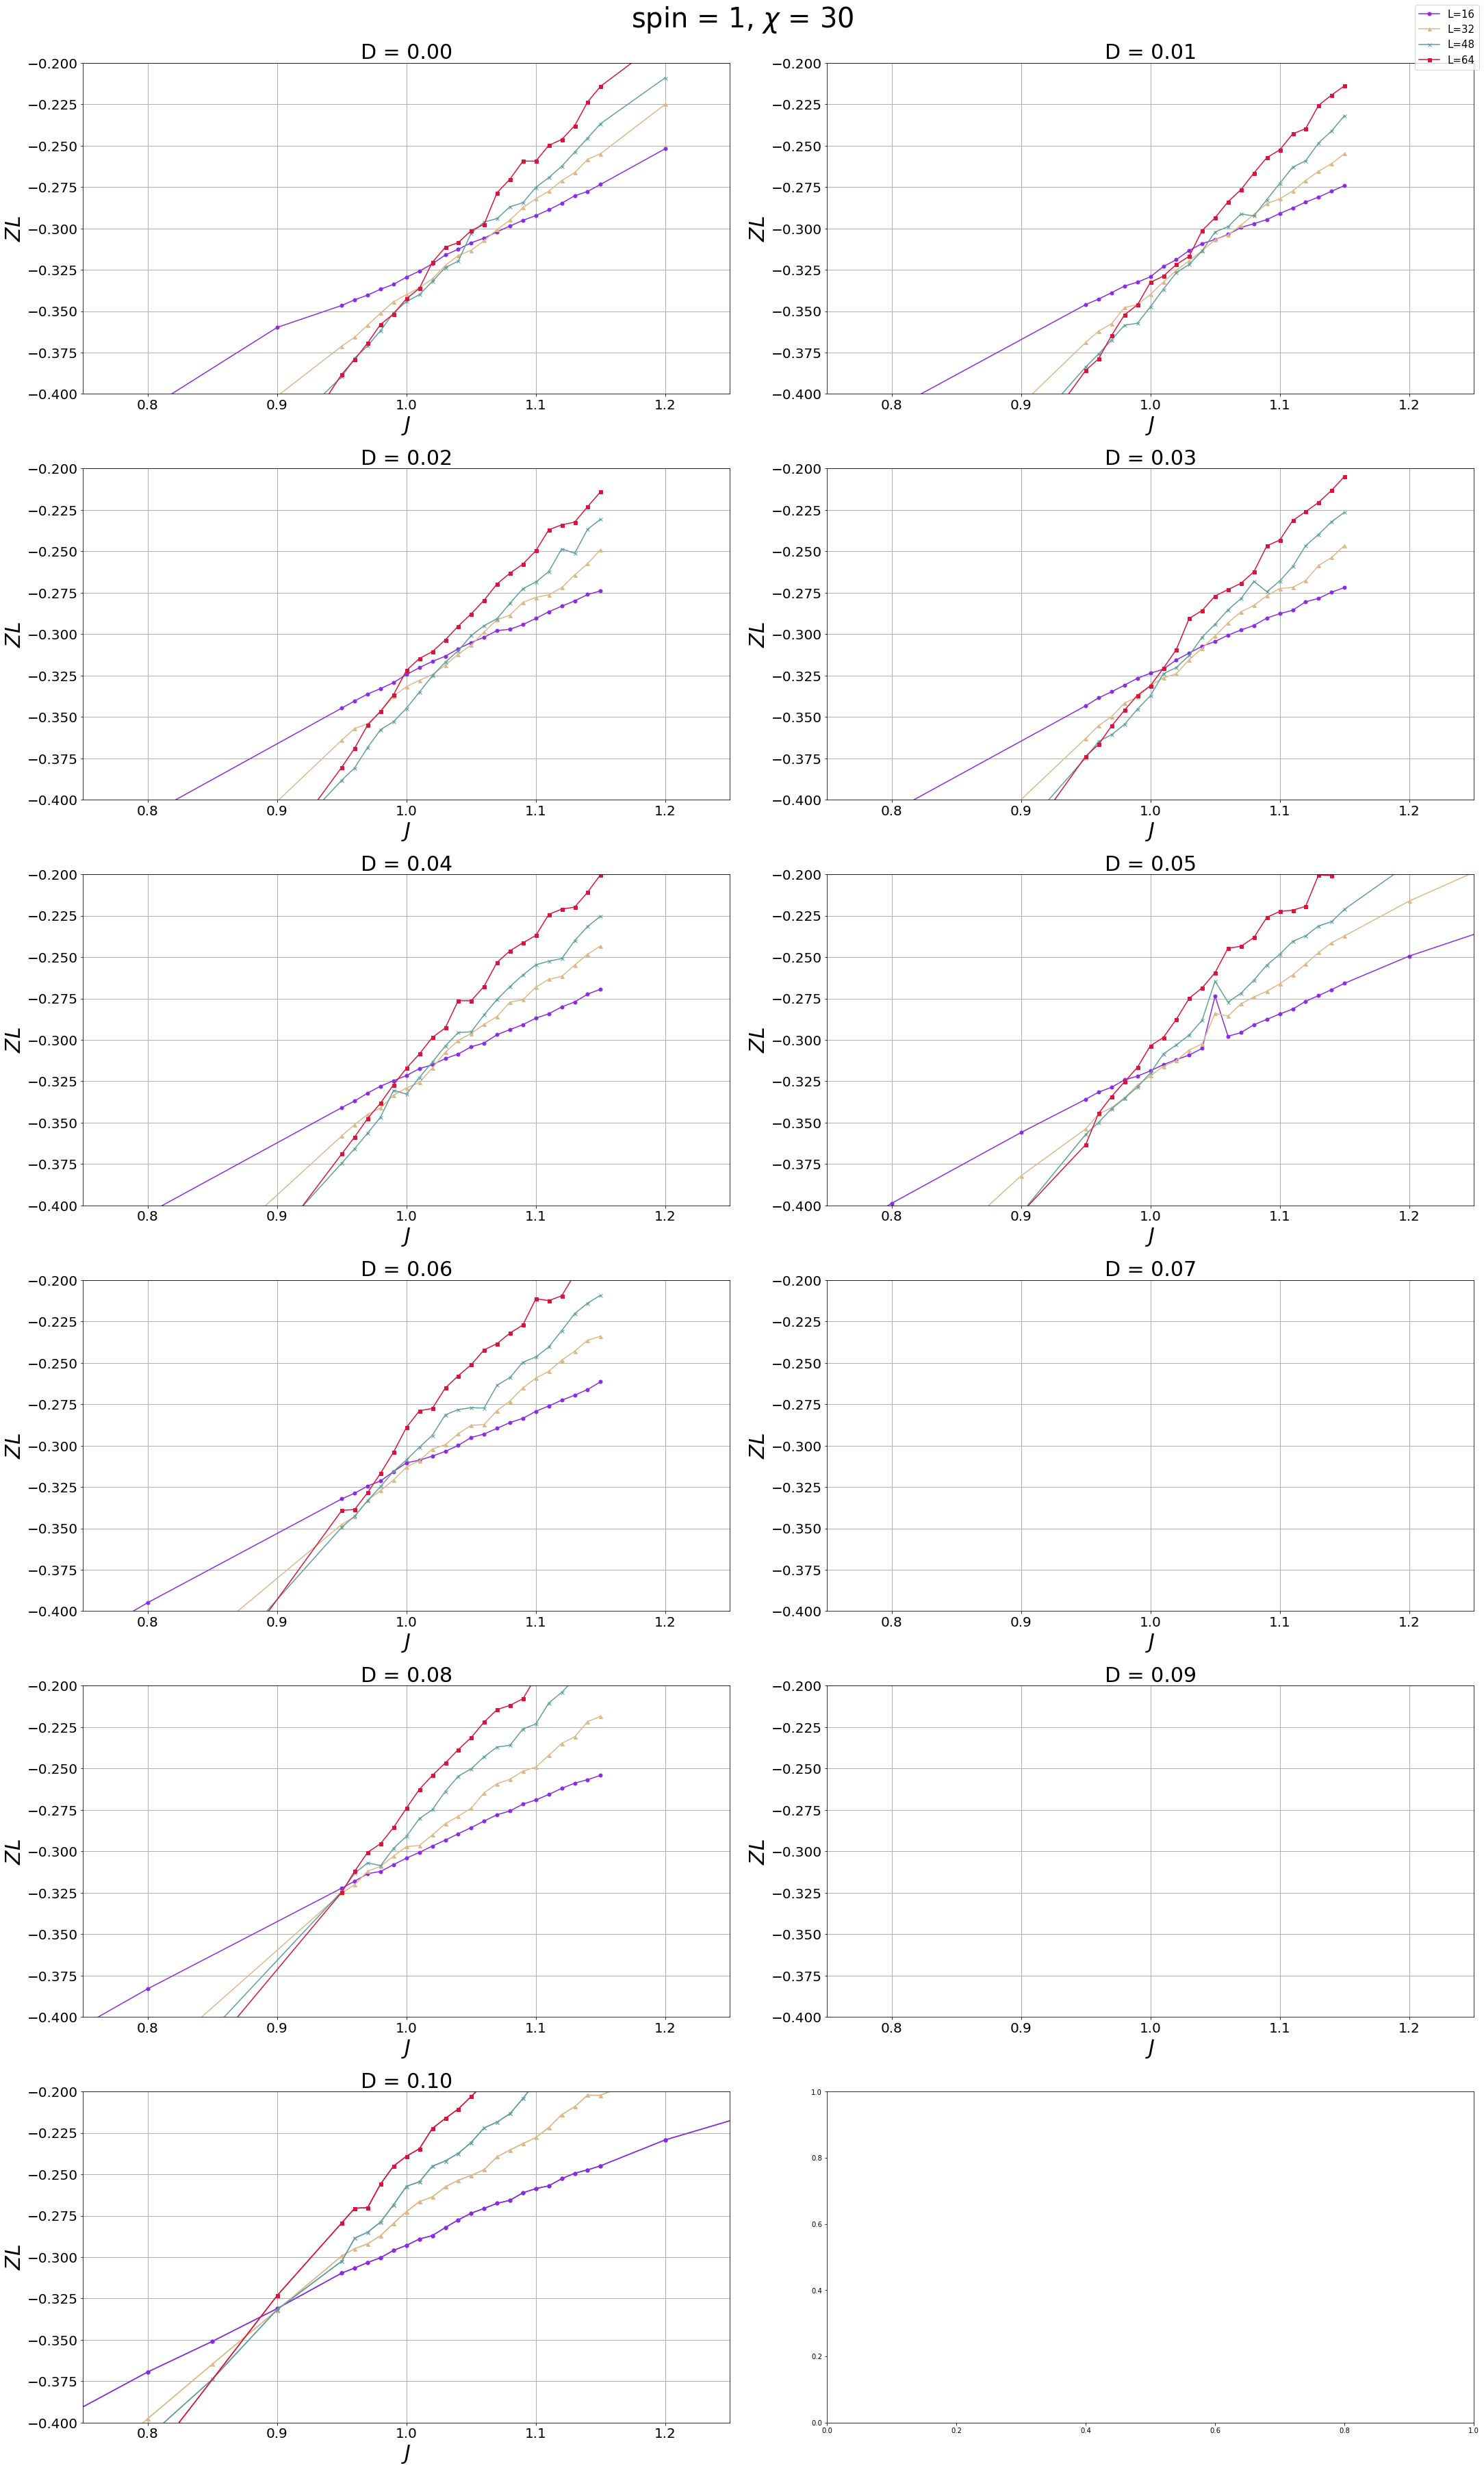

In [61]:
# 固定D, 看L, ZL 對 J 的圖(直切)

OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim000","Dim001","Dim002","Dim003","Dim004","Dim005","Dim006","Dim007","Dim008","Dim009","Dim010"]
Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]

# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(6, 2, constrained_layout=True, figsize=(30,50))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        # ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        ax[int(d/2)][d-2*int(d/2)].set_xlim([0.75, 1.25])                ## set x limit
        ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.4, -0.2])                ## set y limit
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

In [ ]:
# 固定D, 看L, Oz 對 J 的圖(直切)

OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim000","Dim001","Dim002","Dim003","Dim004","Dim005","Dim006","Dim007","Dim008","Dim009","Dim010"]
Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(6, 2, constrained_layout=True, figsize=(30,50))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1.5])                       ## set x limit
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.05])                      ## set y limit
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

### **<font color = green>D</font>** = 0.11 ~ 0.20

In [ ]:
# 固定D, 看L, ZL 對 J 的圖(直切)

OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim011","Dim012","Dim013","Dim014","Dim015","Dim016","Dim017","Dim018","Dim019","Dim020"]
Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]

# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(5, 2, constrained_layout=True, figsize=(30,40))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 6])                         ## set x limit
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

In [ ]:
# 固定D, 看L, Oz 對 J 的圖(直切)

OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim011","Dim012","Dim013","Dim014","Dim015","Dim016","Dim017","Dim018","Dim019","Dim020"]
Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(5, 2, constrained_layout=True, figsize=(30,40))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1.5])                       ## set x limit
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.05])                      ## set y limit
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

### **<font color = green>D</font>** = 0.20 ~ 0.30

In [ ]:
# 固定D, 看L, ZL 對 J 的圖(直切)

OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim021","Dim022","Dim023","Dim024","Dim025","Dim026","Dim027","Dim028","Dim029","Dim030"]
Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]

# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(5, 2, constrained_layout=True, figsize=(30,40))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 6])                         ## set x limit
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

In [ ]:
# 固定D, 看L, Oz 對 J 的圖(直切)

OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim021","Dim022","Dim023","Dim024","Dim025","Dim026","Dim027","Dim028","Dim029","Dim030"]
Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(5, 2, constrained_layout=True, figsize=(30,40))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1.5])                       ## set x limit
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.05])                      ## set y limit
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()

### **<font color = green>D</font>** = 0.40 ~ 2.00

In [ ]:
# 固定D, 看L, ZL 對 J 的圖(直切)

OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim040","Dim050","Dim080","Dim120","Dim160","Dim200"]
Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]

# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(3, 2, constrained_layout=True, figsize=(30,20))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 6])                         ## set x limit
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

In [ ]:
# 固定D, 看L, Oz 對 J 的圖(直切)

OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim040","Dim050","Dim080","Dim120","Dim160","Dim200"]
Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(3, 2, constrained_layout=True, figsize=(30,20))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1.5])                       ## set x limit
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.05])                      ## set y limit
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()

## **fitting and find crossing point (直切)**


-------------------- D = 0.1 --------------------
         J1                   J2
L32-L16 [0.906059683761482]
L48-L32 [0.9078111021472735, 0.9671736219744301]
L64-L48 [0.8637528823957449]


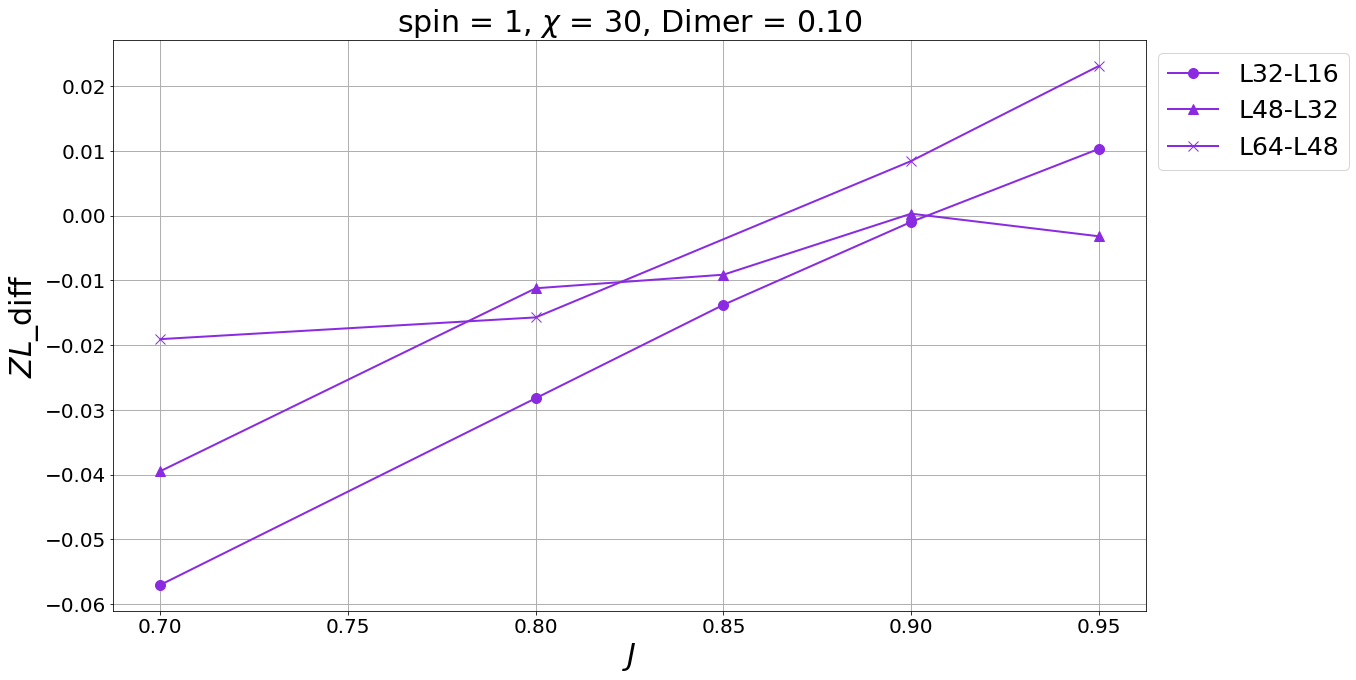

In [68]:
OrderPara = "ZL"
Para = "ZL"

Ls = [16,32,48,64]
Dimer = ["Dim010"]
Jdis = ALL_Jdis[70:96]
n_point = 4

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
    print("\n-------------------- D = "+ str(D) +" --------------------")
    print("         J1", "                  J2")

    for l in range(len(Ls)-1):
        L1 = Ls[l]
        L2 = Ls[l+1]
        f_L1 = pd.DataFrame(columns = ['Jdis', 'ZL'])
        f_L2 = pd.DataFrame(columns = ['Jdis', 'ZL'])
        f_diff = pd.DataFrame(columns = ['Jdis', 'diff'])
        ignore_num = 0

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            file_L1 = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M)\
            +'_'+ OrderPara +'.csv'
            file_L2 = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M)\
            +'_'+ OrderPara +'.csv'
            
            if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                ignore_num += 1
                continue
            
            df_L1 = pd.read_csv(file_L1)
            df_L2 = pd.read_csv(file_L2)

            mean_L1 = {'Jdis':J, 'ZL':df_L1[Para][0]}
            mean_L2 = {'Jdis':J, 'ZL':df_L2[Para][0]}
            mean_diff = {'Jdis':J, 'diff':df_L2[Para][0]-df_L1[Para][0]}

            f_L1.loc[j-ignore_num] = mean_L1
            f_L2.loc[j-ignore_num] = mean_L2
            f_diff.loc[j-ignore_num] = mean_diff

        plt.plot(f_diff['Jdis'], f_diff['diff'], marr[l], color=carr[d], markersize = font_size/3, linewidth = font_size/15, label = 'L%d-L%d' %(L2,L1))

        ids = find_id(f_diff)
        Js, ys = fitting_point(f_L1, f_L2, ids, "Jdis", Para, n_point)
        print(("L"+str(L2)+"-"+"L"+str(L1)), Js)

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$J$', fontsize=font_size)
plt.ylabel(r'$ZL$_diff', fontsize=font_size)
# plt.xlim(0.4, 0.7)
# plt.ylim(0.1, 0.3)
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, Dimer = %.2f' % (spin, M, D), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Fix **<font color = red>L</font>**, look **<font color = yellow>J</font>**, **Order Parameter** vs **<font color = green>D</font>**

In [ ]:
OrderPara = "ZL"   ## Choose SOP or ZL
Ls = [32]
# Dimer = ["Dim000","Dim002","Dim004","Dim006","Dim008","Dim010"]
Dimer = ALL_Dimer
Jdis = ["Jdis050","Jdis060"]

if (OrderPara == "SOP"):
    Para = "O^z"
    plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
if (OrderPara == "ZL"):
    Para = "ZL"
    plt.ylabel(r'$ZL$', fontsize=font_size)
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)
            mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]}  
            dfplt.loc[d] = mean
         
        plt.plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[j], markersize = font_size/3, label = 'J=%.2f, L=%d' %(J, L))
        plt.errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=font_size/2, capthick=font_size/15, color=carr[j], label=None)
            
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$D$', fontsize=font_size)
# plt.xlim(0.9,1.2)  
# plt.ylim(0, 0.1)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d' % (spin, M), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
# plt.savefig( dimer + '_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Fix **<font color = red>L</font>**, look **<font color = green>D</font>**, **Order Parameter** vs **<font color = yellow>J</font>**

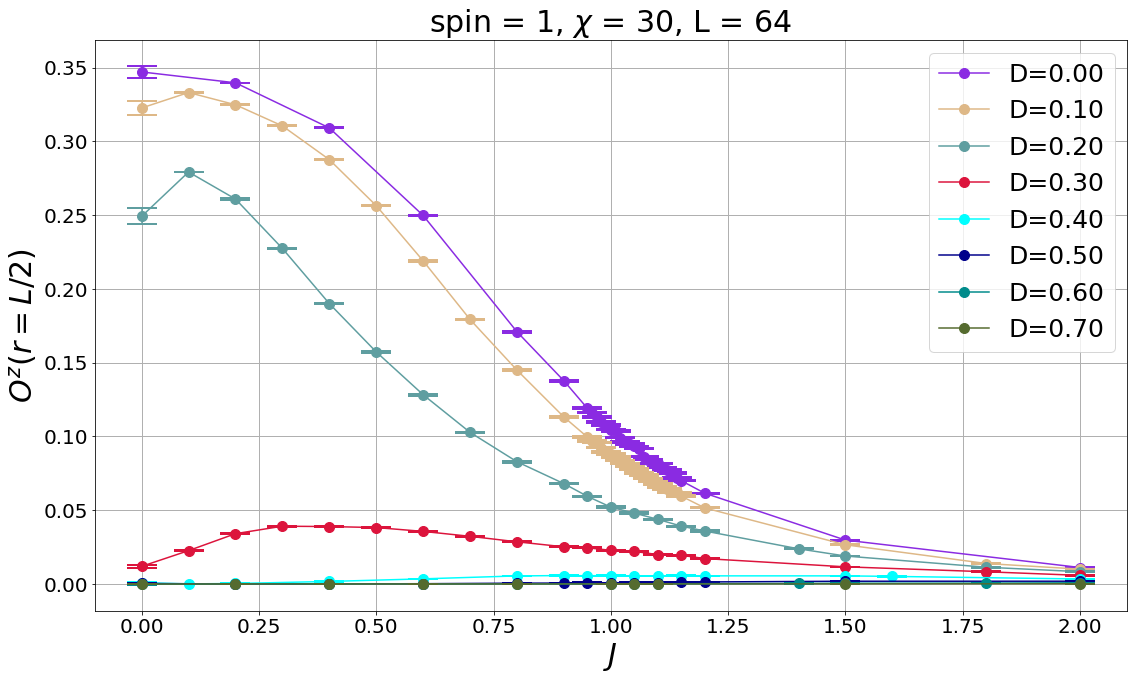

In [22]:
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [64]
Dimer = ["Dim000","Dim010","Dim020","Dim030","Dim040","Dim050","Dim060","Dim070"]
# Dimer = ["Dim000","Dim002","Dim004","Dim006","Dim008","Dim010"]
Jdis = ALL_Jdis

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
            
            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)
            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[j] = mean

        plt.plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l+d], markersize = font_size/3, label = 'D=%.2f' %(D))
        plt.errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=font_size/2, capthick=font_size/15, color=carr[l+d], label=None)
            
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$J$', fontsize=font_size)
plt.ylabel(ylable, fontsize=font_size)
# plt.xlim(2.5,6)
# plt.ylim(0.0, 0.02)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, L = %d' % (spin, M, L), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
# plt.savefig( dimer + '_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Fix **<font color = green>D</font>**, look **<font color = yellow>J</font>**, **Order Parameter** vs 1/**<font color = red>L</font>**

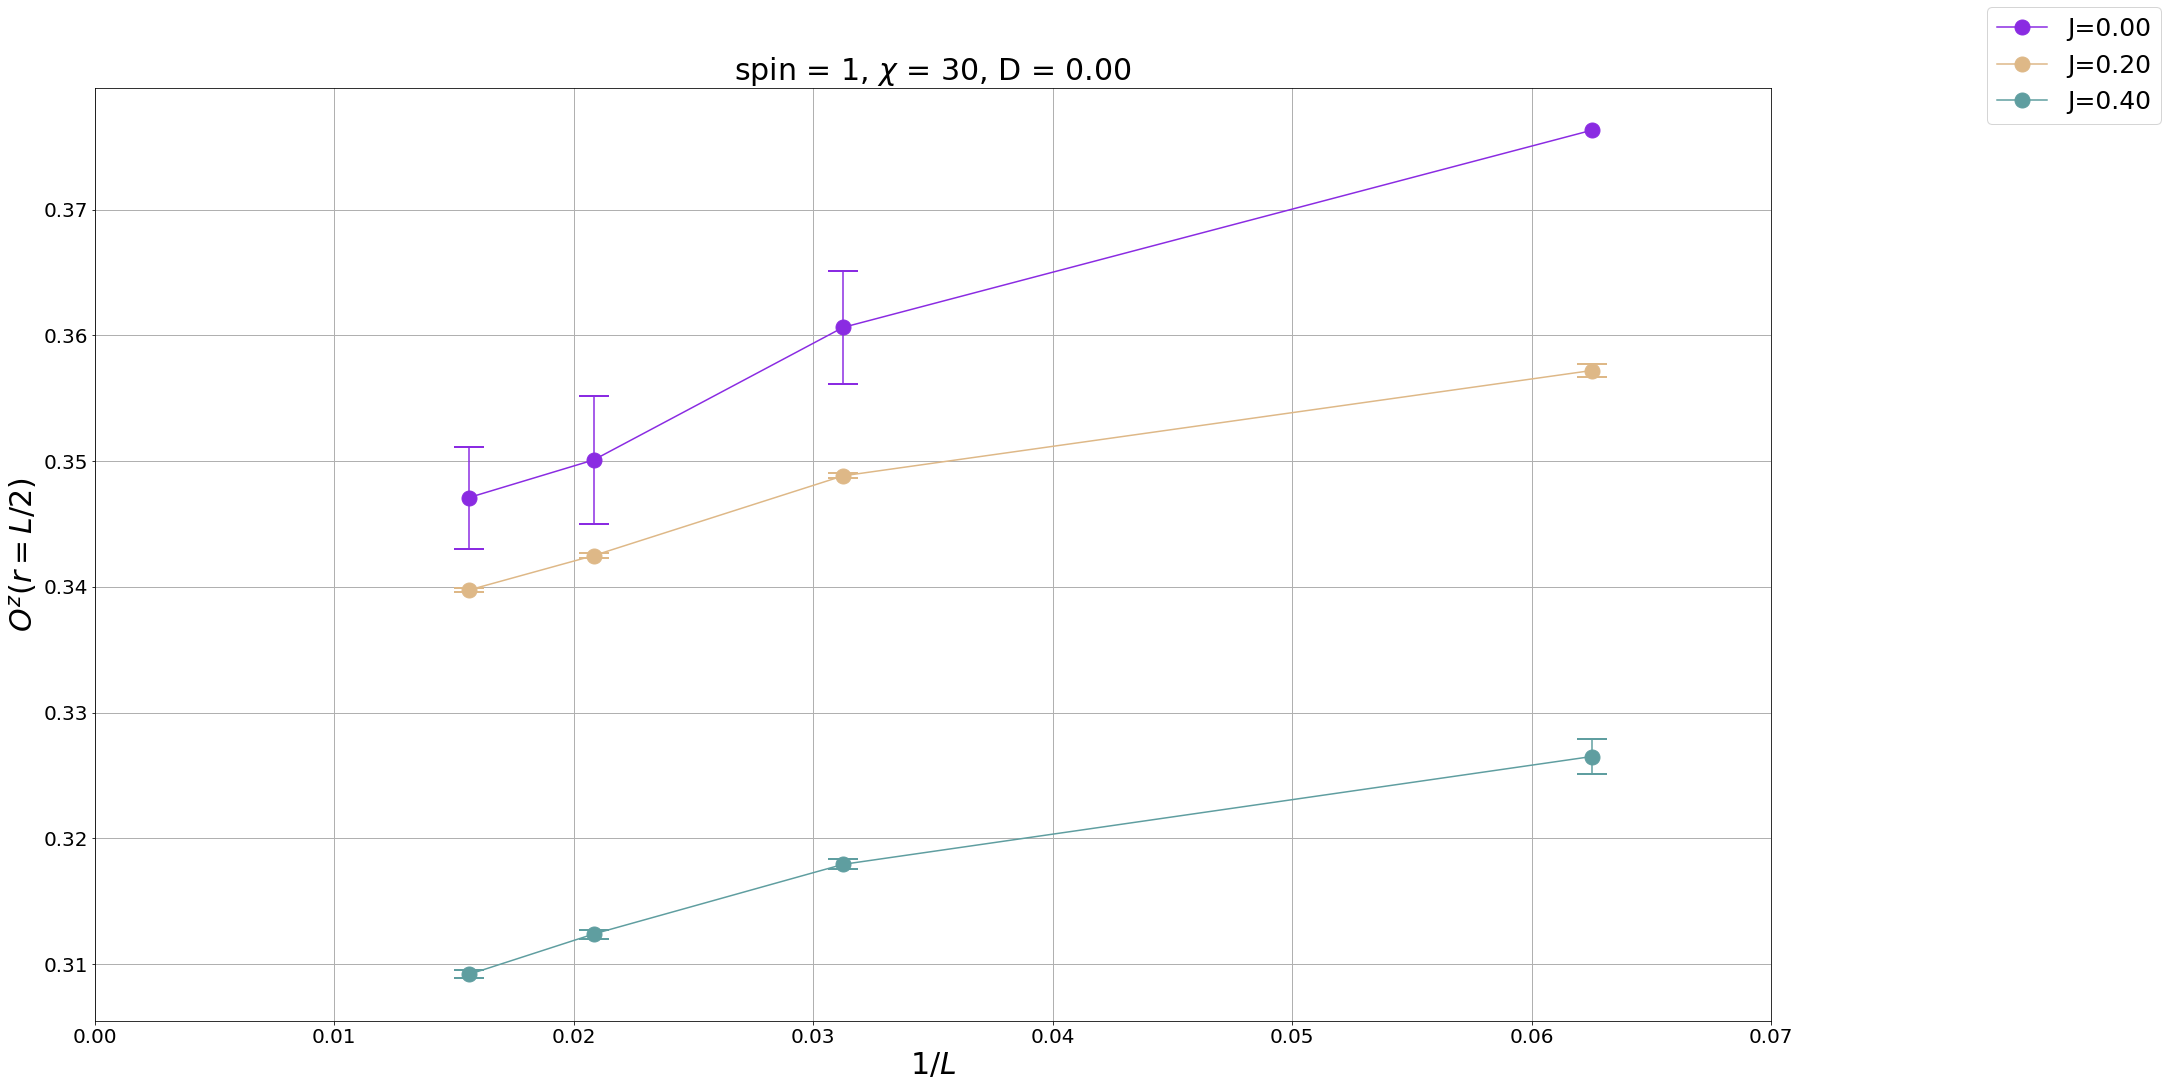

In [28]:
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,96,128,256]
Dimer = ["Dim000"]
Jdis = ["Jdis000","Jdis020","Jdis040"]
# Jdis = ["Jdis000"]

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(30,15))
for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
    
    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['1/L', Para, 'error'])     
        
        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'1/L':1/L, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'1/L':1/L, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[l] = mean

        plt.rcParams['figure.figsize'] = (15, 10)
        plt.plot(dfplt["1/L"], dfplt[Para], marr[int(j/6)], color=carr[j%6], markersize = 15, label = 'J=%.2f' %(J))
        plt.errorbar(dfplt["1/L"], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=font_size/2, capthick=font_size/15, color=carr[j%6], label=None)
            
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$1/L$', fontsize=font_size)
plt.ylabel(ylable, fontsize=font_size)
plt.xlim(0,0.07)
# plt.ylim(0, 0.45)
# plt.xscale('log')
# plt.yscale('log')
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, D = %.2f' % (spin, M, D), fontsize=font_size)
plt.legend(bbox_to_anchor=(1.24, 1.1), loc = 'best',fontsize=font_size*5/6)
# plt.savefig( dimer + '_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()

In [ ]:
## Multiplot
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,96,128,256]
# Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim025","Dim030","Dim035","Dim040","Dim045","Dim050","Dim055","Dim060","Dim065","Dim070"]
Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim030","Dim040","Dim050","Dim055","Dim060"]
Jdis = ["Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070","Jdis080","Jdis090","Jdis100"]
# Jdis = ["Jdis000"]

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

fig, ax = plt.subplots(5, 2, constrained_layout=True, figsize=(30,50))

for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['1/L', Para, 'error'])  

        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'1/L':1/L, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'1/L':1/L, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[l] = mean

        if (d == len(Dimer)-1):
            ax[int(d/2)][d-2*int(d/2)].plot(dfplt['1/L'], dfplt[Para], marr[int(j/6)], color=carr[j%6], markersize = 15, label = 'Jdis=%.2f' %(J))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['1/L'], dfplt[Para], marr[int(j/6)], color=carr[j%6], markersize = 15)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['1/L'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[j%6], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$1/L$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        ax[int(d/2)][d-2*int(d/2)].set_xlim([0,0.07])
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.5])
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=font_size*5/6)

# plt.xscale('log')
# plt.yscale('log')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()

## Fix **<font color = yellow>J</font>**, look **<font color = green>D</font>**, **Order Parameter** vs 1/**<font color = red>L</font>**

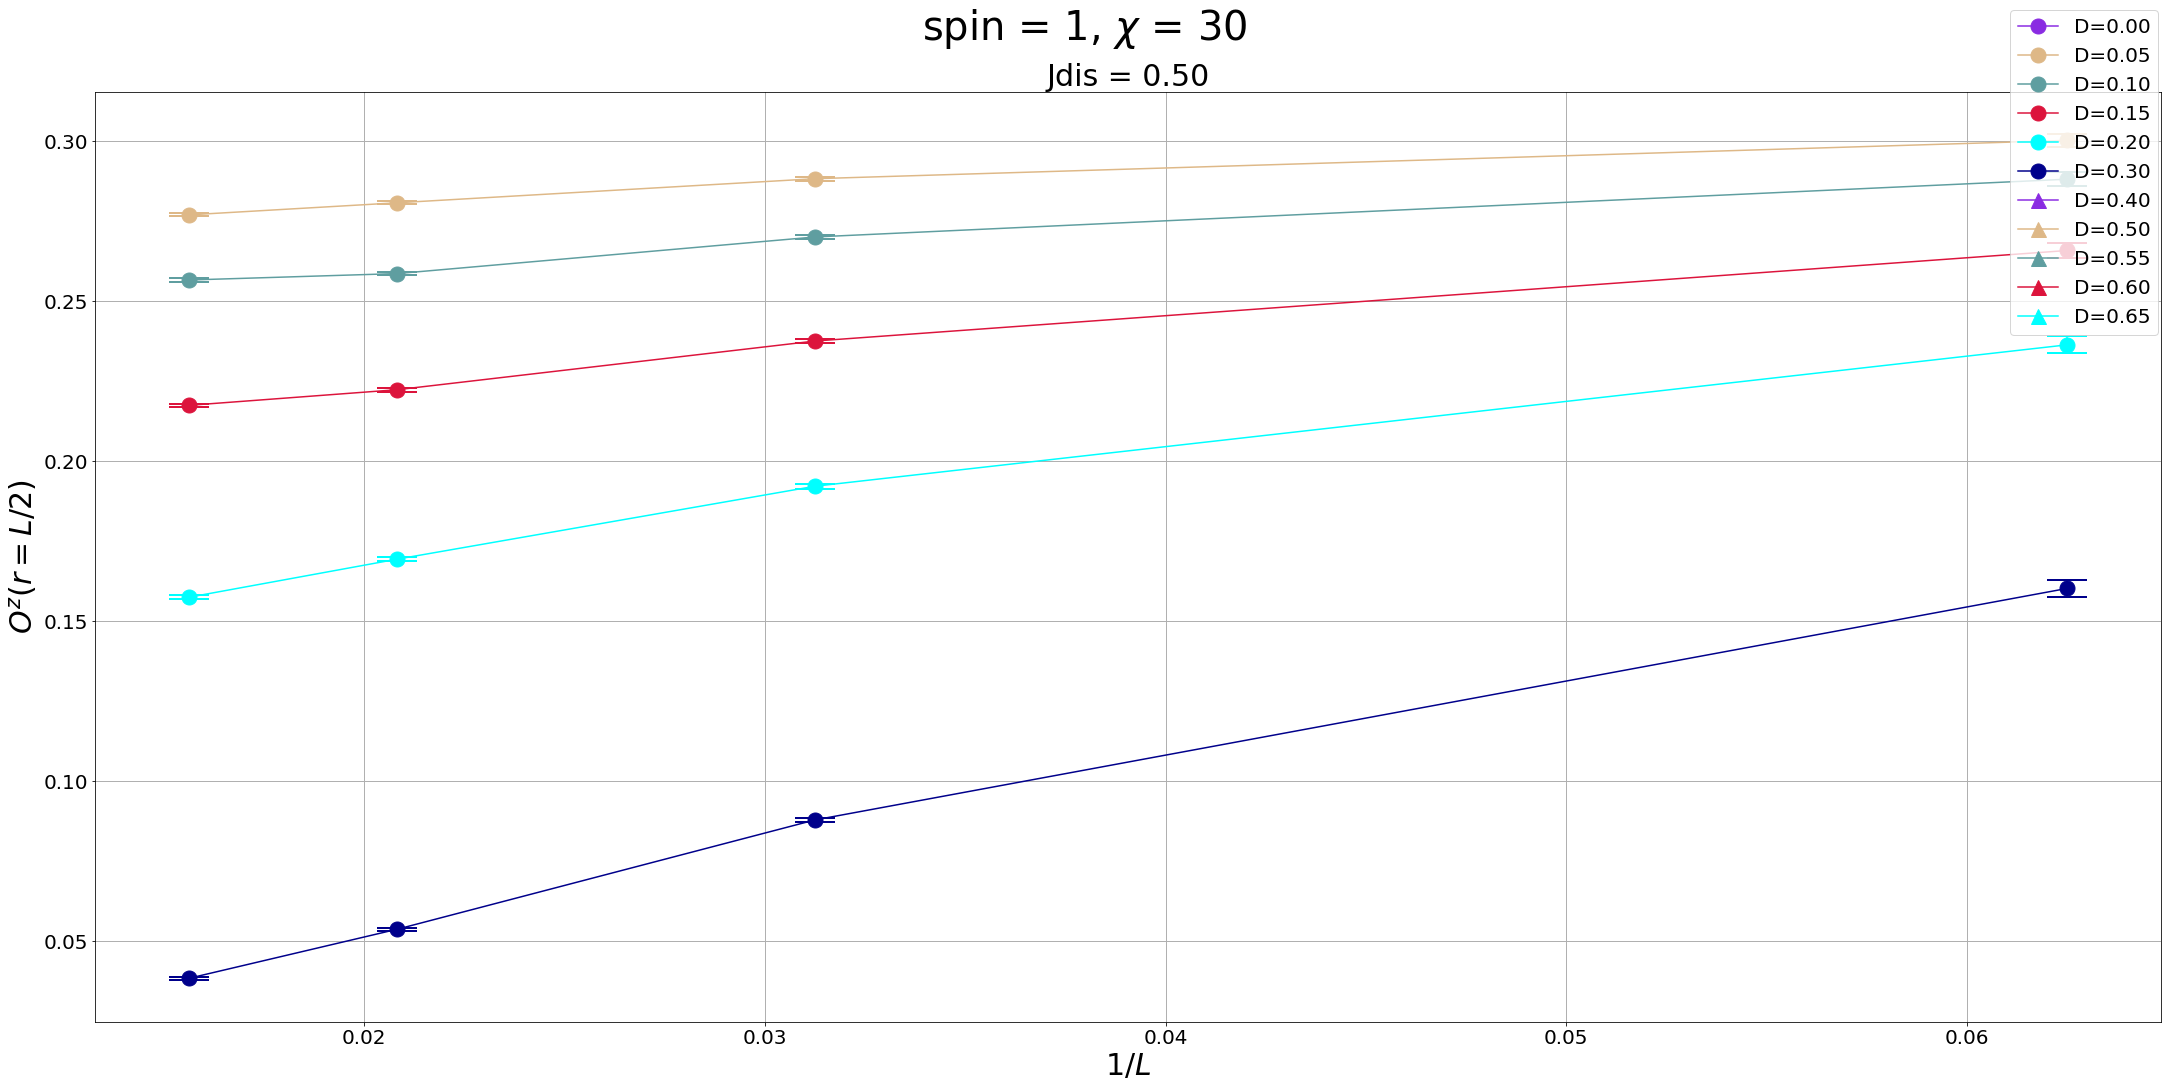

In [33]:
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,96,128,256]
Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim030","Dim040","Dim050","Dim055","Dim060","Dim065"]
Jdis = ["Jdis050"]

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(30,15))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['1/L', Para, 'error'])  

        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'1/L':1/L, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'1/L':1/L, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[l] = mean

        ax.plot(dfplt['1/L'], dfplt[Para], marr[int(d/6)], color=carr[d%6], markersize = 15, label = 'D=%.2f' %(D))
        ax.errorbar(dfplt['1/L'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[d%6], label=None)
        ax.set_xlabel(r'$1/L$', fontsize=30)
        ax.set_ylabel(ylable, fontsize=30)
        ax.tick_params(axis='x', labelsize=20) 
        ax.tick_params(axis='y', labelsize=20)
        ax.set_title("Jdis = %.2f" %(J), fontsize=30)
        ax.grid(linestyle='-', linewidth=1)
        # ax.set_xlim([0,0.07])
        # ax.set_ylim([0, 0.5])
        # ax.legend(loc = 'best',fontsize=font_size*5/6)

# plt.xscale('log')
# plt.yscale('log')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()  

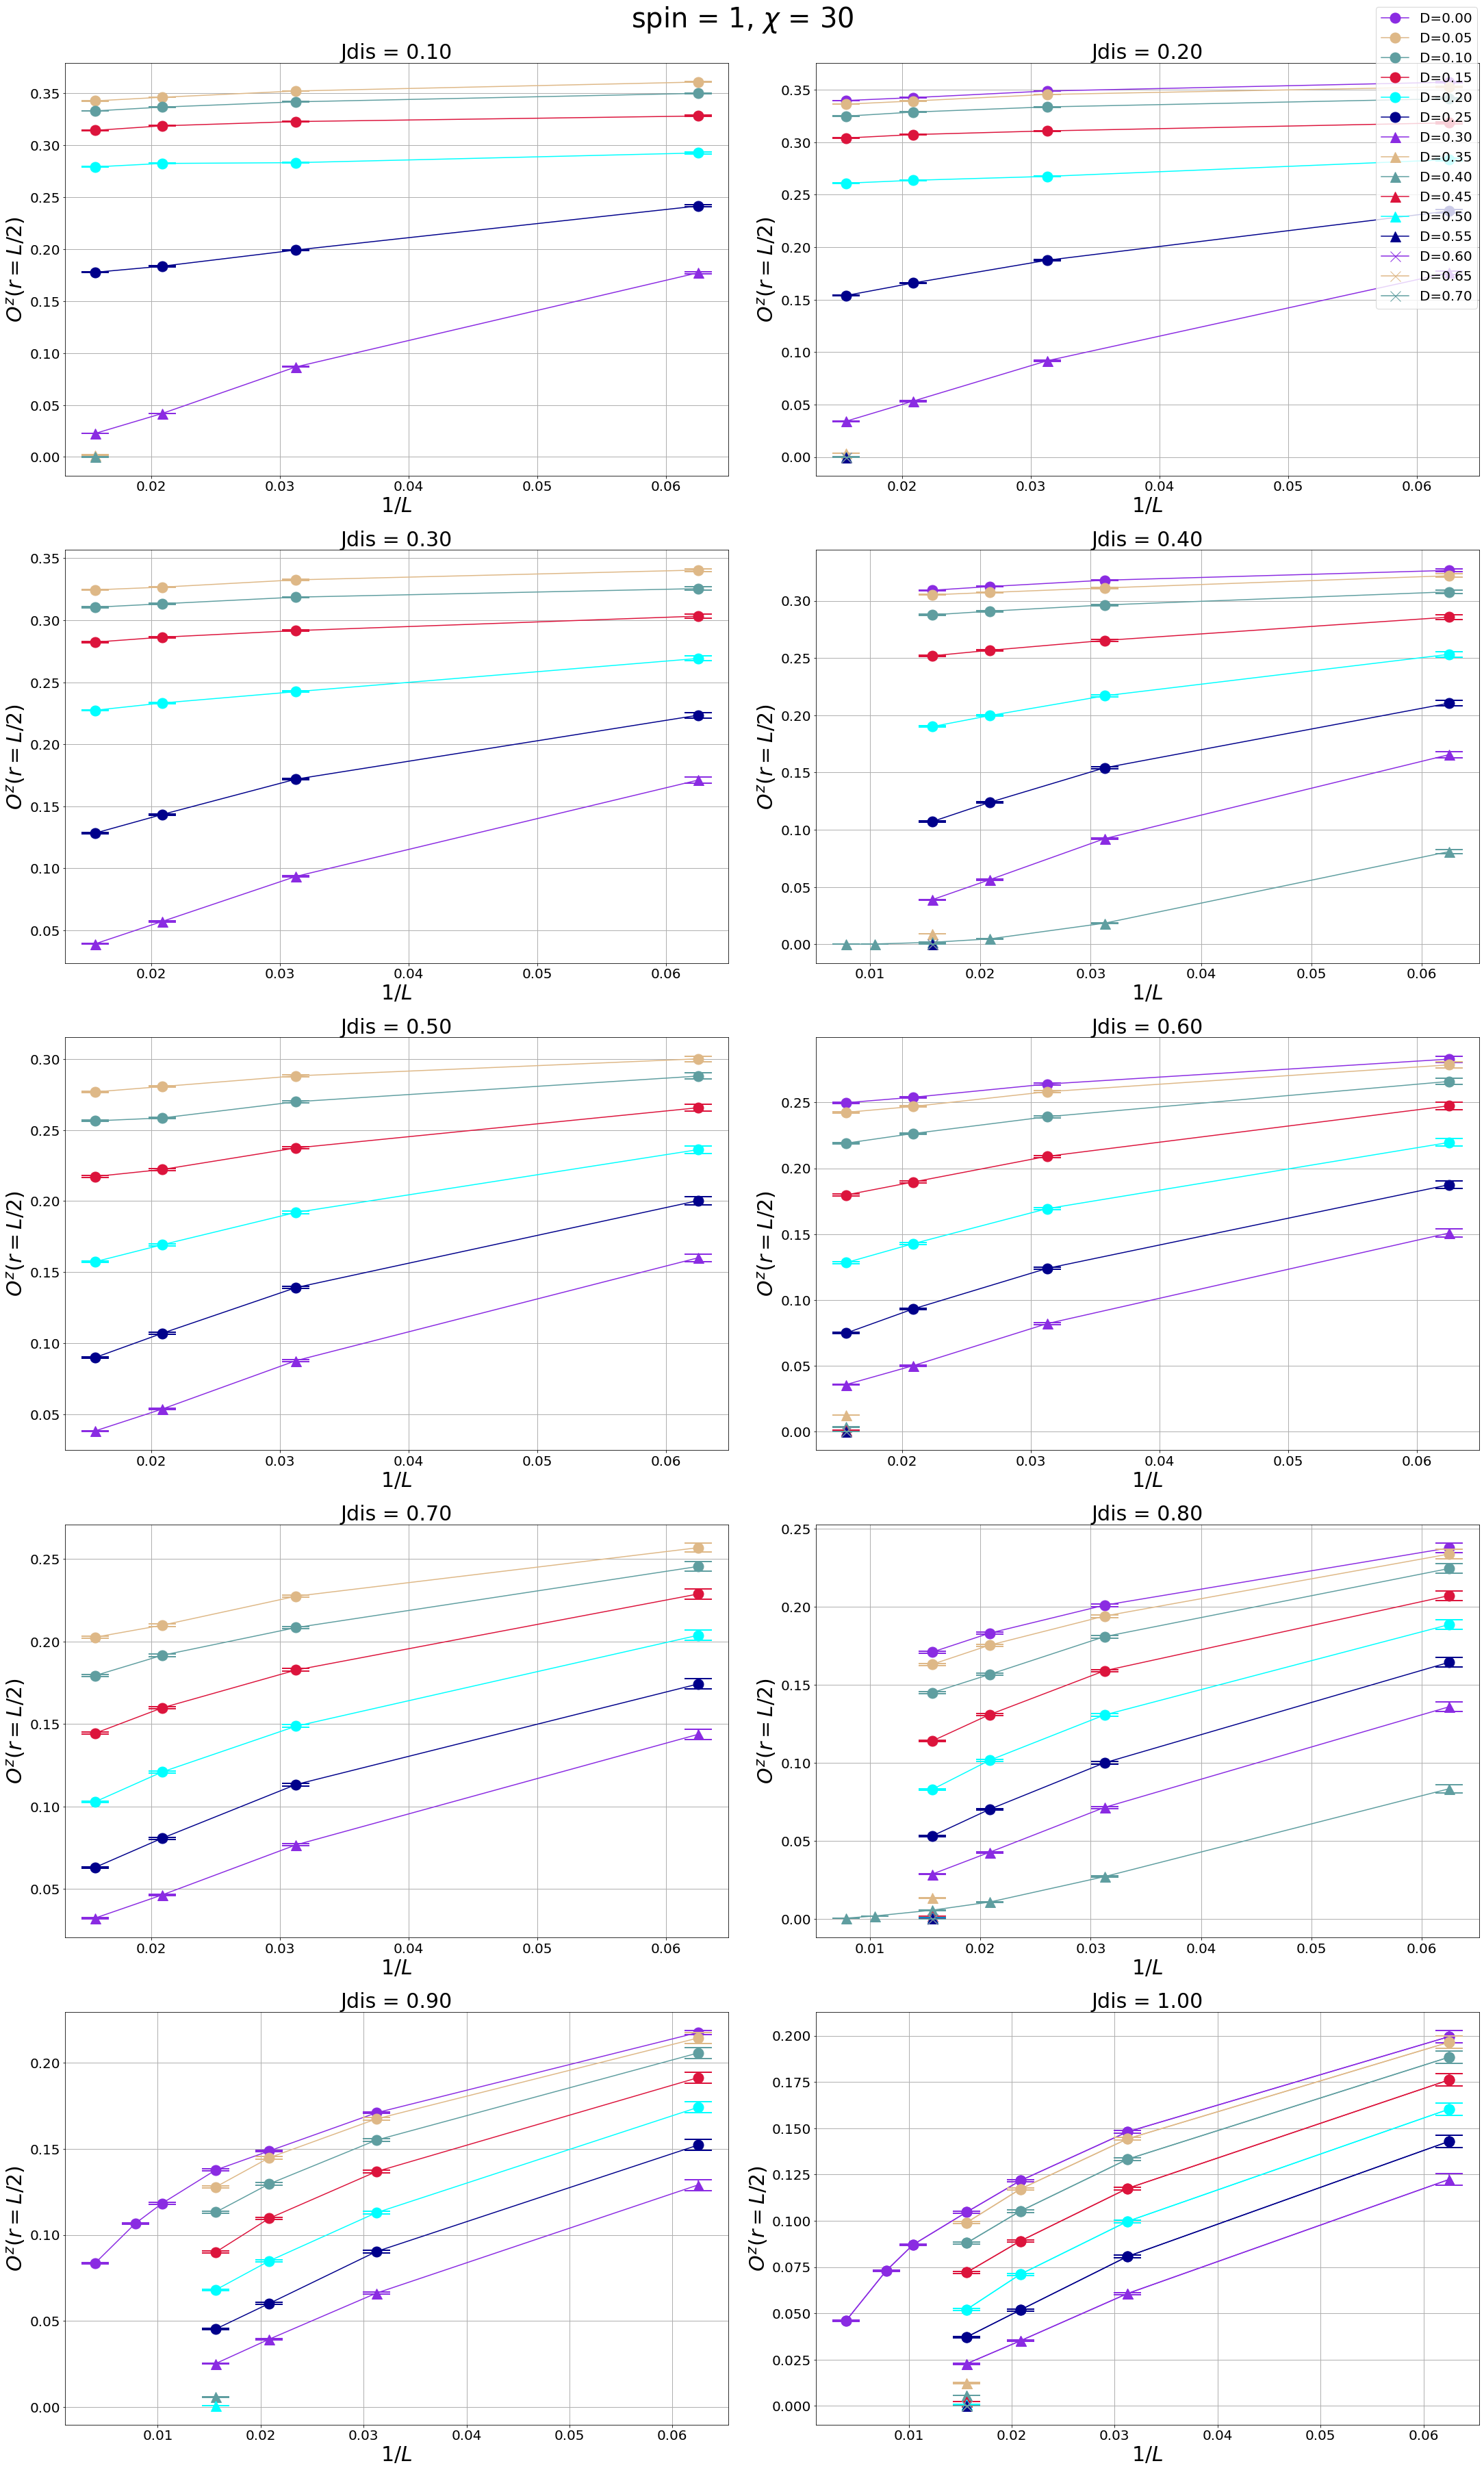

In [34]:
## Multiplot
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,96,128,256]
# Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim025","Dim030","Dim035","Dim040","Dim045","Dim050","Dim055","Dim060","Dim065","Dim070"]
Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim025","Dim030","Dim035","Dim040","Dim045","Dim050","Dim055","Dim060","Dim065","Dim070"]
Jdis = ["Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070","Jdis080","Jdis090","Jdis100"]
# Jdis = ["Jdis000"]

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

fig, ax = plt.subplots(5, 2, constrained_layout=True, figsize=(30,50))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['1/L', Para, 'error'])  

        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'1/L':1/L, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'1/L':1/L, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[l] = mean

        if (j == len(Jdis)-1):
            ax[int(j/2)][j-2*int(j/2)].plot(dfplt['1/L'], dfplt[Para], marr[int(d/6)], color=carr[d%6], markersize = 15, label = 'D=%.2f' %(D))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['1/L'], dfplt[Para], marr[int(d/6)], color=carr[d%6], markersize = 15)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['1/L'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[d%6], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$1/L$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        # ax[int(j/2)][j-2*int(j/2)].set_xlim([0,0.07])
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([0, 0.5])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=font_size*5/6)

# plt.xscale('log')
# plt.yscale('log')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()

## **Phase Diagram**

In [ ]:
## 以縱切得到的圖
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(30,15))

myfile = '/home/liusf/tSDRG_DataAnalysis/PhaseDiagram_D-J.csv'
df1 = pd.read_csv(myfile)
ax[0].plot(df1['D'], df1['J'], '-o', color="red", markersize = font_size/3, label = 'Straight cut')
ax[0].plot(df1['D'], df1['J2'], '-o', color="red", markersize = font_size/3)
## 以橫切得到的圖
myfile = '/home/liusf/tSDRG_DataAnalysis/PhaseDiagram_J-D.csv'
df2 = pd.read_csv(myfile)
ax[0].plot(df2['D'], df2['J'], '-o', color="blue", markersize = font_size/3, label = 'Crosscut')
ax[0].plot(df2['D2'], df2['J'], '-o', color="blue", markersize = font_size/3)

ax[0].set_xlabel(r'$D$', fontsize=30)
ax[0].set_ylabel(r'$J$', fontsize=30)
ax[0].tick_params(axis='x', labelsize=20) 
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_title('old', fontsize=30)
ax[0].grid(linestyle='-', linewidth=1)
# ax[0].set_xlim([0, 0.2])                  
# ax[0].set_ylim([0, 1])          
ax[0].legend(loc = 'best',fontsize=font_size*5/6)

## 以縱切得到的圖
myfile = '/home/liusf/tSDRG_DataAnalysis/PhaseDiagram_D-J_new.csv'
df1 = pd.read_csv(myfile)
ax[1].plot(df1['D'], df1['J'], '-o', color="red", markersize = font_size/3, label = 'Straight cut')
ax[1].plot(df1['D'], df1['J2'], '-o', color="red", markersize = font_size/3)
## 以橫切得到的圖
myfile = '/home/liusf/tSDRG_DataAnalysis/PhaseDiagram_J-D_new.csv'
df2 = pd.read_csv(myfile)
ax[1].plot(df2['D'], df2['J'], '-o', color="blue", markersize = font_size/3, label = 'Crosscut')
ax[1].plot(df2['D2'], df2['J'], '-o', color="blue", markersize = font_size/3)

ax[1].set_xlabel(r'$D$', fontsize=30)
ax[1].set_ylabel(r'$J$', fontsize=30)
ax[1].tick_params(axis='x', labelsize=20) 
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_title('new', fontsize=30)
ax[1].grid(linestyle='-', linewidth=1)
# ax[1].set_xlim([0, 0.2])                  
# ax[1].set_ylim([0, 1])               
ax[1].legend(loc = 'best',fontsize=font_size*5/6)

# plt.savefig( dimer + '_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()

## **Contourf Plot** 

[0.05 0.1  0.15 0.2  0.25 0.3 ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1]


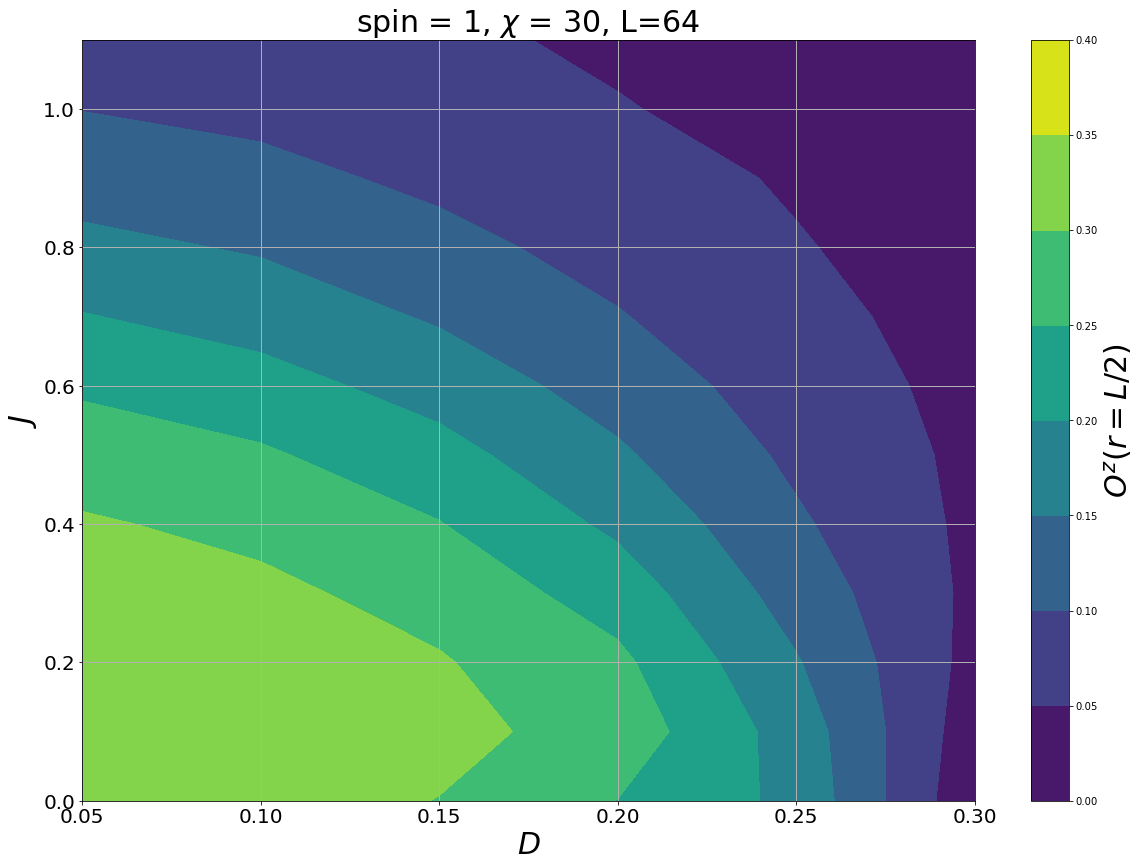

In [53]:
col, row  = 6, 12
D = np.round(np.linspace(0.05, 0.3, num=col), 2)
J = np.round(np.linspace(0, 1.1, num=row), 2)
Ls = [64]
x, y = np.meshgrid(D,J)
z = [[0 for _ in range(col)] for _ in range(row)]
print(D)
print(J)

OrderPara = "SOP"

if (OrderPara == "SOP"):
    Para = "O^z"
    label = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    label = r'$ZL$'

for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(J)):
        if (len(str(J[j])) == 3):
            jdis = 'Jdis' + str(J[j])[0] + str(J[j])[2] + '0'
        if (len(str(J[j])) == 4):
            jdis = 'Jdis' + str(J[j])[0] + str(J[j])[2] + str(J[j])[3]
            
        for d in range(len(D)):
            if (len(str(D[d])) == 3):
                dimer = 'Dim' + str(D[d])[0] + str(D[d])[2] + '0'
            if (len(str(D[d])) == 4):
                dimer = 'Dim' + str(D[d])[0] + str(D[d])[2] + str(D[d])[3]

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
            +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                print(str(L) + "_" + jdis + "_" + dimer + " missing data")
                continue

            df = pd.read_csv(myfile)
            z[j][d] = df[Para][0]
    # print(z)

    fig = plt.figure(figsize=(20, 14))
    fig.add_subplot(1,1,1)
    levels = np.linspace(0, 0.4, 9)            ## 固定顏色條上下限跟切幾等分
    cs = plt.contourf(x, y, z, levels=levels)
    cb = plt.colorbar()                         ## 顯示顏色條
    cb.set_label(label, fontsize=font_size)
    plt.xticks(fontsize=font_size/1.5)
    plt.yticks(fontsize=font_size/1.5)
    # plt.xticks([])
    # plt.yticks([])
    plt.xlabel(r'$D$', fontsize=font_size)
    plt.ylabel(r'$J$', fontsize=font_size)
    # plt.xlim(0,0.7)  
    # plt.ylim(0.0, 0.02)
    # plt.xscale('log')
    # plt.yscale('log')
    plt.grid(linestyle='-', linewidth=1)
    plt.title('spin = %s, $\chi$ = %d, L=%d' % (spin, M, L), fontsize=font_size)

# plt.savefig('圖四.png', format='png')
plt.show()